<a href="https://www.kaggle.com/code/aminizahra/bayesian-ml?scriptVersionId=91283130" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Bayesian ML – Dynamic Sharpe Ratios and Pairs Trading**

### **Note: This notebook is just a training notebook to get acquainted with the commands.**

# **Import & Install Libraries**

In [1]:
pip install pymc3

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.1

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from scipy import stats

In [4]:
import pandas_datareader.data as web

In [5]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

In [6]:
import theano
import pymc3 as pm
import arviz as az
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

In [7]:
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

# **Create Model**

In [8]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [9]:
attendees = np.array([33, 30, 25, 32, 34, 33, 35, 33, 36])

# **Some of the available distribution in PyMC3:**

**pm.Uniform()**

**pm.Normal()**

**pm.MvNormal()**

**pm.StudentT()**

**pm.Beta()**

**pm.Dirichlet()**

**pm.Exponential()**

**pm.Gamma()**

**pm.Pareto()**

**pm.Laplace()**

# **And some of the discrete densities:**

**pm.Categorical()**

**pm.Binomial()**

**pm.Bernoulli()**

**pm.Poisson()**

**pm.Geometric()**

**pm.NegativeBinomial()**

In [10]:
with pm.Model() as model:
    mu = pm.Exponential('mu', 0.5)
    number_of_attendees = pm.Poisson('count', mu = mu,observed = attendees)
    map = pm.find_MAP()

In [11]:
model.basic_RVs

[mu_log__ ~ TransformedDistribution, count ~ Poisson]

In [12]:
print("mu:", "\t", map["mu"]) #average + bias of our prior

mu: 	 30.631578956515078


# **Markov Chain Monte Carlo (MCMC)**

## **2000 Samples**

In [13]:
with pm.Model() as model:
    mu = pm.Exponential('mu', 0.5)
    number_of_attendees = pm.Poisson('count', mu = mu,observed = attendees)
    samples = pm.sample(draws = 2000, tune = 500, cores = 2, chains = 2)

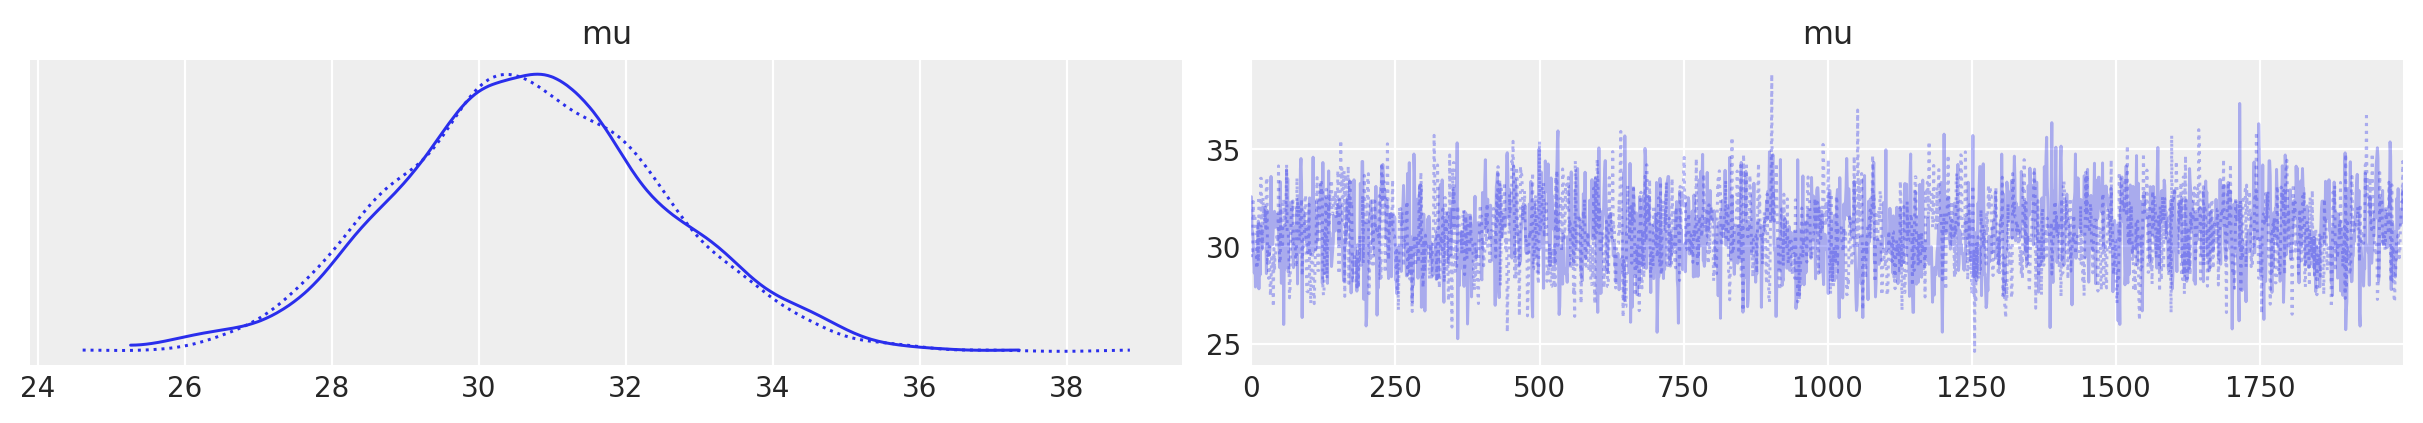

In [14]:
_ = az.plot_trace(samples)

## **6000 Samples**

In [15]:
with pm.Model() as model:
    mu = pm.Exponential('mu', 0.5)
    number_of_attendees = pm.Poisson('count', mu = mu,observed = attendees)
    samples = pm.sample(draws = 6000, tune = 500, cores = 2, chains = 2)

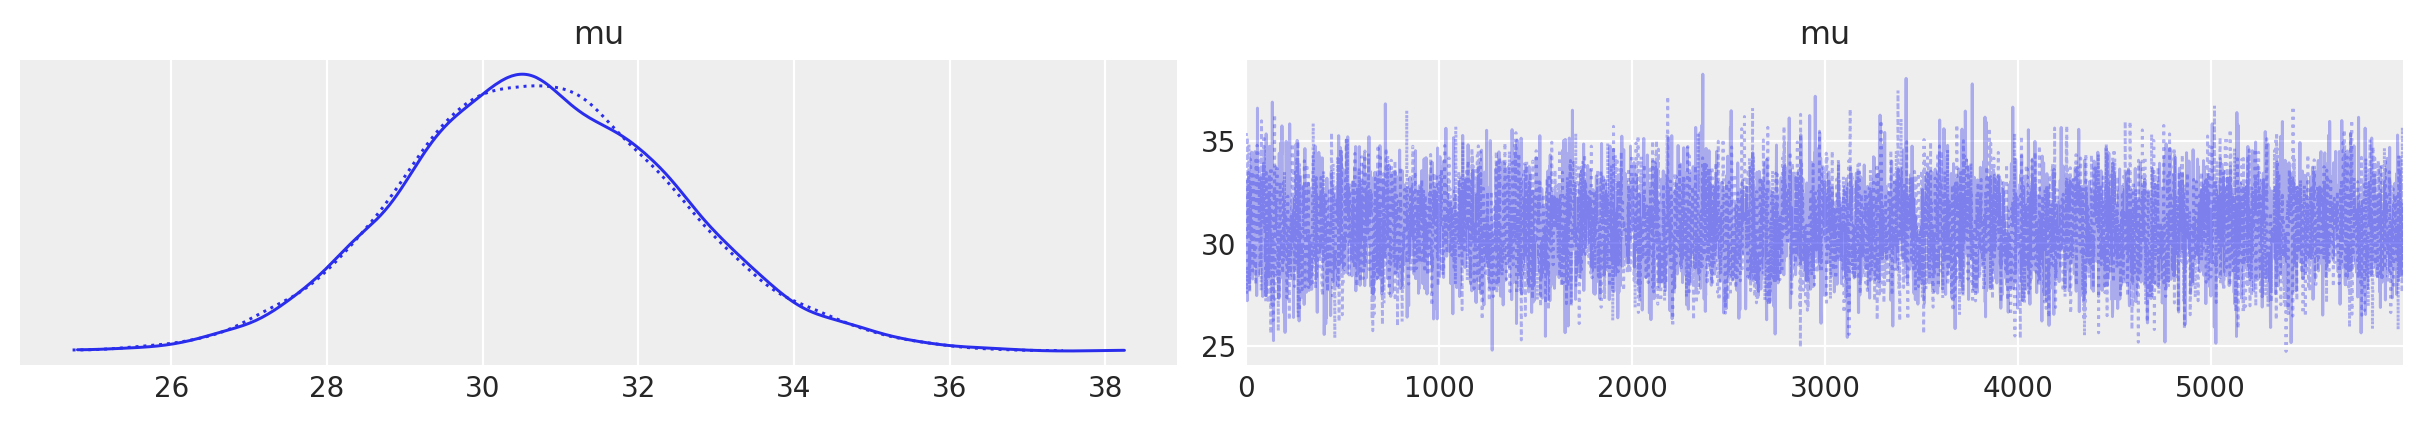

In [16]:
_ = az.plot_trace(samples)

In [17]:
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,30.729,1.793,27.379,34.175,0.026,0.018,4686.0,7363.0,1.0


### **Note: The closer the value of r_hat is to "1", the better. And the best value is "1".**

# **Variational Inference in PyMC3**

In [18]:
with pm.Model() as model:
    mu = pm.Exponential('mu', 0.5)
    number_of_attendees = pm.Poisson('count', mu = mu,observed = attendees)
    approx = pm.fit() #Gaussian distribution

In [19]:
samples = approx.sample(10000)

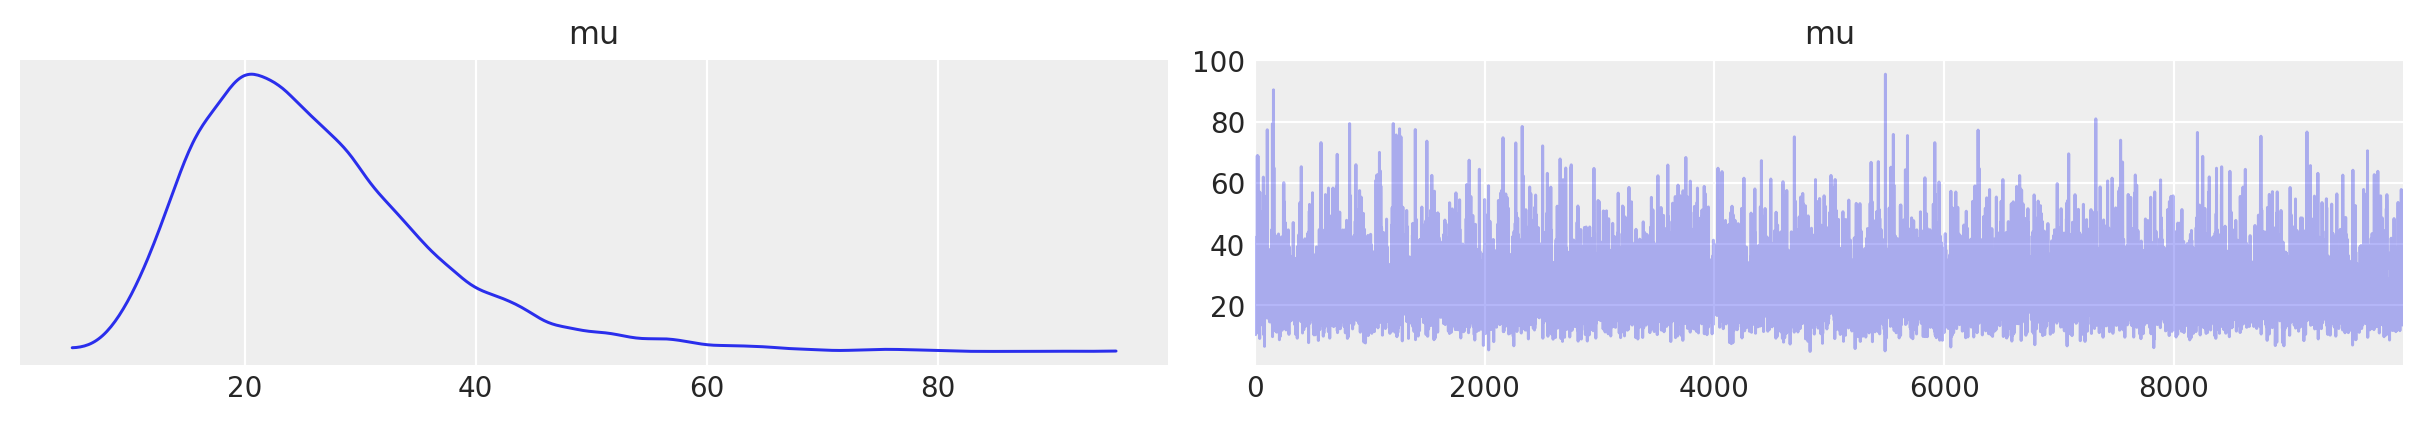

In [20]:
_ = az.plot_trace(samples)

### **Note: Mean is about 20. oh no, it's so bad.**

In [21]:
with pm.Model() as model:
    mu = pm.Exponential('mu', 0.5)
    number_of_attendees = pm.Poisson('count', mu = mu,observed = attendees)
    approx = pm.fit(method = pm.SVGD()) #‘svgd’ for Stein Variational Gradient Descent

In [22]:
samples = approx.sample(10000)

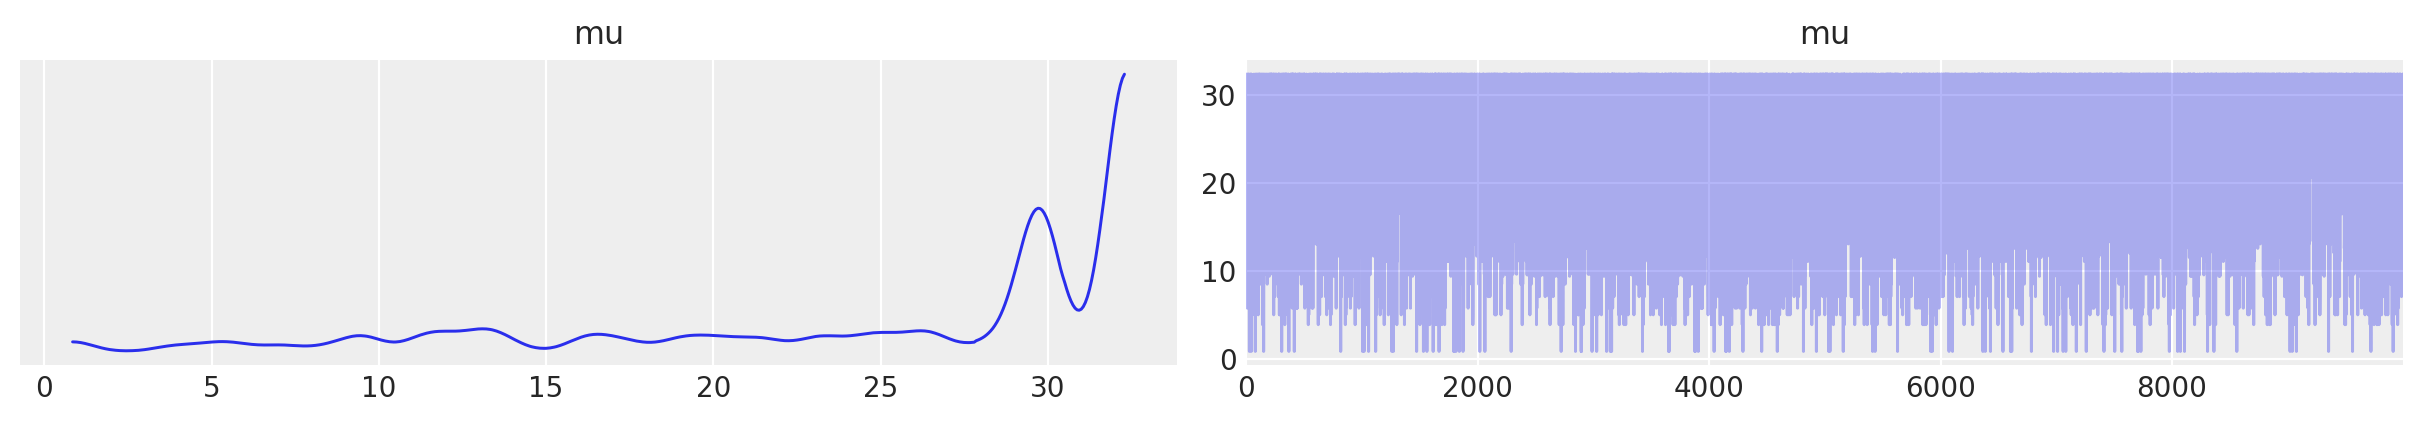

In [23]:
_ = az.plot_trace(samples)

# **Taken from the 10th chapter of the Machine Learning for Algorithmic Trading book and presented by Amirabbas Asadi.**